## COGS 181 Final Project - Few Shot Learning with CIFAR-10 Data

### Overview of Experiment:
- Running "Few-Shot Learning" on CIFAR-10 Dataset 
- Using two models: AlexNet and ResNet
- Steps for learning:
  1. Subset data into few-shot data sets into k classes with n samples, for each k sample has query set
  2. run model on the subset of the data, record train error and validation error 
  3. after training is done, we run the model on the test set and record test error
  4. repeat for all subsets to get an avg score for train, validatio, test error

#### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.models as models
from PIL import Image

#### Import Data - CIFAR-10

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


tensor([9, 1, 9, 2])


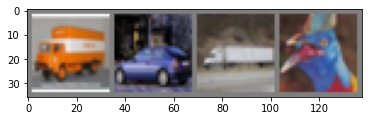

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
truck   car truck  bird


In [3]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(labels)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(classes)
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [5]:
#Subset Train and Test Data
classes_of_interest = ['cat', 'dog', 'bird', 'frog', 'deer', 'horse']
labels_of_interest = [3, 5, 2, 6, 4, 7]
#label_indices = [trainset.class_to_idx[label] for label in labels_of_interest]
train_subset = [img for img in trainset if img[1] in labels_of_interest]
test_subset = [img for img in testset if img[1] in labels_of_interest]

In [6]:
def getFewShotData(dataset, classes, num_support_samples):

    support_set = []
    query_set = []
    for class_name in classes:
        class_indices = np.where(np.array(dataset.targets) == dataset.class_to_idx[class_name])[0]
        selected_indices = np.random.choice(class_indices, num_support_samples + 1, replace=False)
        for idx, sample_idx in enumerate(selected_indices):
            data, label = dataset.data[sample_idx], dataset.targets[sample_idx]
            if idx < num_support_samples:
                support_set.append((data, label))
            else:
                query_set.append((data, label))
    return support_set, query_set

In [7]:
# Define classes and number of samples for training tasks
num_samples = 5
train_classes_task1 = ['cat', 'dog']
train_classes_task2 = ['horse', 'deer']
# Define classes and number of samples for test tasks
test_classes = ['frog', 'bird']

# Create FewShotDataset instances for training and test tasks
train_task1_support, train_task1_query = getFewShotData(trainset, train_classes_task1, num_samples)
train_task2_support, train_task2_query = getFewShotData(trainset, train_classes_task2, num_samples)
test_support, test_query = getFewShotData(trainset, test_classes, num_samples)


In [8]:
# Visualize support set for training task 1
#print("Train Task 1 Support Set:")
#for i, (data, label) in enumerate(train_task1_support):
    #plt.imshow(data)
    #plt.title(f"Label: {label}")
    #plt.axis('off')
    #plt.show()

### ResNet Model

In [9]:
# Function to create ResNet model
def create_resnet_model(num_layers, activation_func):
    if num_layers == 18:
        model = models.resnet18(pretrained=True)
    elif num_layers == 34:
        model = models.resnet34(pretrained=True)
    elif num_layers == 50:
        model = models.resnet50(pretrained=True)
    elif num_layers == 101:
        model = models.resnet101(pretrained=True)
    elif num_layers == 152:
        model = models.resnet152(pretrained=True)
    else:
        raise ValueError("Invalid number of layers. Choose from 18, 34, 50, 101, 152.")

    if activation_func == 'ReLU':
        activation = nn.ReLU()
    elif activation_func == 'Sigmoid':
        activation = nn.Sigmoid()
    elif activation_func == 'LeakyReLU':
        activation = nn.LeakyReLU()
    else:
        raise ValueError("Invalid activation function. Choose from ReLU, Sigmoid, LeakyReLU.")

    # Replace the last layer with a new fully connected layer based on the number of classes in the dataset
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(train_classes_task1))

    return model

### Pre-process the data

In [10]:
def preprocess_data(support_set, query_set):
    """
    Preprocess data: Convert to Tensors and apply necessary transformations.
    Upscale the images to 224x224 to match ResNet input.
    Assumes data is in NumPy array format.
    """
    upscale_transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
        transforms.Resize((224, 224)),  # Upscale the image to 224x224
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize for ResNet
    ])
    
    # Apply transformations
    support_images = torch.stack([upscale_transform(Image.fromarray(image)) for image, _ in support_set])
    support_labels = torch.tensor([label for _, label in support_set])
    
    query_images = torch.stack([upscale_transform(Image.fromarray(image)) for image, _ in query_set])
    query_labels = torch.tensor([label for _, label in query_set])
    
    return support_images, support_labels, query_images, query_labels

### Defining Training Function --> choosing support, test, query sets and showing accuracy/loss with every epoch

In [11]:
def train_meta_learning(model, tasks, optimizer, num_epochs=10):
    loss_func = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        epoch_loss = 0
        correct_predictions = 0
        total_predictions = 0
        
        for task_support, task_query in tasks:
            # Preprocess task data
            support_images, support_labels, query_images, query_labels = preprocess_data(task_support, task_query)
            
            unique_labels = torch.unique(support_labels)
            label_mapping = {int(label.item()): i for i, label in enumerate(unique_labels)}
            # Remap target labels in the support set
            support_labels_mapped = torch.tensor([label_mapping[label.item()] for label in support_labels])
            
            unique_labels = torch.unique(query_labels)
            label_mapping = {int(label.item()): i for i, label in enumerate(unique_labels)}
            # Remap target labels in the support set
            query_labels_mapped = torch.tensor([label_mapping[label.item()] for label in query_labels])
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass: Support set
            output_support = model(support_images)
            loss_support = loss_func(output_support, support_labels_mapped)
            
            # Forward pass: Adaptation on the support set
            num_adaptation_steps = 3  # Can range from 1 to 5 given a small support set
            for _ in range(num_adaptation_steps):
                output_support = model(support_images)
                loss = loss_func(output_support, support_labels_mapped)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    

            # Evaluate on Query Set
            with torch.no_grad():
                output_query = model(query_images)
                loss_query = loss_func(output_query, query_labels_mapped)
                epoch_loss += loss_query.item()
                
                # Calculate accuracy
                _, predicted = torch.max(output_query, 1)
                correct_predictions += (predicted == query_labels_mapped).sum().item()
                total_predictions += len(query_labels_mapped)
                
        # Calculate average loss and accuracy for the epoch
        epoch_loss /= len(tasks)
        accuracy = correct_predictions / total_predictions
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {accuracy}')

### Choosing Parameters for ResNet Model

In [12]:
num_layers = 34 #choose between 18, 34, 50, 101, 152

activation_func = 'ReLU' #choose between ReLU, Sigmoid, or LeakyReLU

lr = 0.001

num_epochs = 10 #change as needed

# Define the ResNet model
RNmodel = create_resnet_model(num_layers, activation_func)

#Define Loss Func
loss_func = nn.CrossEntropyLoss()

optimizer_name = "Adam"  # Or "SGD"
if optimizer_name == "SGD":
    optimizer = optim.SGD(RNmodel.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
elif optimizer_name == "Adam":
    optimizer = optim.Adam(RNmodel.parameters(), lr=0.001, weight_decay=1e-4)

/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### ResNet Model Training with Loss and Accuracy Calculations

In [13]:
# Group the tasks
train_tasks = [(train_task1_support, train_task1_query), (train_task2_support, train_task2_query)]

# Train the model using the meta-learning approach
train_meta_learning(RNmodel, train_tasks, optimizer, num_epochs)


/opt/conda/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1/10, Loss: 1.6181050539016724, Accuracy: 0.25
Epoch 2/10, Loss: 3.16353998798877, Accuracy: 0.5
Epoch 3/10, Loss: 3.578022599220276, Accuracy: 0.0
Epoch 4/10, Loss: 2.4435982406139374, Accuracy: 0.5
Epoch 5/10, Loss: 2.3420921340584755, Accuracy: 0.5
Epoch 6/10, Loss: 2.1449858341366053, Accuracy: 0.5
Epoch 7/10, Loss: 2.0114879477769136, Accuracy: 0.5
Epoch 8/10, Loss: 1.9964606426656246, Accuracy: 0.5
Epoch 9/10, Loss: 1.956016831099987, Accuracy: 0.5
Epoch 10/10, Loss: 1.9115364290773869, Accuracy: 0.5


### Testing Function with Test Loss and Accuracy

In [14]:
def test_meta_learning(model, tasks):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for task_support, task_query in tasks:
        # Preprocess task data
        support_images, support_labels, query_images, query_labels = preprocess_data(task_support, task_query)

        unique_labels = torch.unique(support_labels)
        label_mapping = {int(label.item()): i for i, label in enumerate(unique_labels)}
        # Remap target labels in the support set
        support_labels_mapped = torch.tensor([label_mapping[label.item()] for label in support_labels])

        unique_labels = torch.unique(query_labels)
        label_mapping = {int(label.item()): i for i, label in enumerate(unique_labels)}
        # Remap target labels in the query set
        query_labels_mapped = torch.tensor([label_mapping[label.item()] for label in query_labels])

        # Forward pass: Adaptation on the support set
        num_adaptation_steps = 5  # Can range from 1 to 5 given a small support set
        for _ in range(num_adaptation_steps):
            output_support = model(support_images)
            loss = loss_func(output_support, support_labels_mapped)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()  # Accumulate loss

        # Predictions on the query set after adaptation
        output_query = model(query_images)
        _, predicted = torch.max(output_query, 1)
        total_correct += (predicted == query_labels_mapped).sum().item()
        total_samples += len(query_labels_mapped)

    # Calculate average loss and accuracy
    average_loss = total_loss / (len(tasks) * num_adaptation_steps)
    accuracy = total_correct / total_samples
    return average_loss, accuracy

# Evaluation on the test task
test_task = [(test_support, test_query)]
test_loss, test_accuracy = test_meta_learning(RNmodel, test_task)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Test Loss: 9.200811100006103, Test Accuracy: 0.5


In [15]:
alex_net = models.alexnet(pretrained = True)
print(alex_net)

/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Creating AlexNet Model

In [30]:
def create_alex_net():
    #create the network 
    alex_net = models.alexnet(pretrained = True)
    num_features = alex_net.classifier[6].in_features
    
    #change the last fully connected layer to 2 classes to match our training/test set of 2 classes
    alex_net.classifier[6] = nn.Linear(num_features, 2)
    
    #changing activation_func
#     if activation_func == "Sigmoid":
#         alex_net.features[1] = nn.Sigmoid()  
#         alex_net.features[4] = nn.Sigmoid()
#         alex_net.features[7] = nn.Sigmoid()  
#         alex_net.features[9] = nn.Sigmoid()  
#         alex_net.features[11] = nn.Sigmoid() 
#         alex_net.classifier[2] = nn.Sigmoid()  
#         alex_net.classifier[4] = nn.Sigmoid()
        
#     elif activation_func == "ReLU":
#         alex_net.features[1] = nn.ReLU()  
#         alex_net.features[4] = nn.ReLU() 
#         alex_net.features[7] = nn.ReLU()  
#         alex_net.features[9] = nn.ReLU()   
#         alex_net.features[11] = nn.ReLU()  
#         alex_net.classifier[2] = nn.ReLU() 
#         alex_net.classifier[4] = nn.ReLU() 
    
#     elif activation_func == "LeakyReLU": 
#         alex_net.features[1] = nn.LeakyReLU()  
#         alex_net.features[4] = nn.LeakyReLU() 
#         alex_net.features[7] = nn.LeakyReLU() 
#         alex_net.features[9] = nn.LeakyReLU() 
#         alex_net.features[11] = nn.LeakyReLU()  
#         alex_net.classifier[2] = nn.LeakyReLU()
#         alex_net.classifier[4] = nn.LeakyReLU()
        
#     else:
#         raise ValueError("Invalid activation function. Choose from ReLU, Sigmoid, LeakyReLU.")
        
    return alex_net

In [32]:
alex_net1 = create_alex_net()
print(alex_net1.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


### Initiate the AlexNet Model

In [33]:
alex_net = create_alex_net()

loss_function = nn.CrossEntropyLoss()

optimizer_name = "Adam"  # Or "SGD"
if optimizer_name == "SGD":
    optimizer_an = optim.SGD(alex_net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
elif optimizer_name == "Adam":
    optimizer_an = optim.Adam(alex_net.parameters(), lr=0.001, weight_decay=1e-4)

In [34]:
# Group the tasks
train_tasks = [(train_task1_support, train_task1_query), (train_task2_support, train_task2_query)]

# Train the model using the meta-learning approach
train_meta_learning(alex_net, train_tasks, optimizer_an, num_epochs)

Epoch 1/10, Loss: 0.6974229514598846, Accuracy: 0.5
Epoch 2/10, Loss: 0.3621535450220108, Accuracy: 0.75
Epoch 3/10, Loss: 0.40773092955350876, Accuracy: 0.75
Epoch 4/10, Loss: 0.21430905163288116, Accuracy: 1.0
Epoch 5/10, Loss: 0.6792782545089722, Accuracy: 0.5
Epoch 6/10, Loss: 0.7558100819587708, Accuracy: 0.25
Epoch 7/10, Loss: 1.3157851696014404, Accuracy: 0.25
Epoch 8/10, Loss: 0.6938441395759583, Accuracy: 0.75
Epoch 9/10, Loss: 3.837217628955841, Accuracy: 0.25
Epoch 10/10, Loss: 1.0269682705402374, Accuracy: 0.5


In [37]:
test_task1 = [(test_support, test_query)]
test_loss1, test_accuracy1 = test_meta_learning(alex_net, test_task)
print(f'Test Loss: {test_loss1}, Test Accuracy: {test_accuracy1}')

Test Loss: 0.6158188581466675, Test Accuracy: 0.0
